In [1]:
import pandas as pd
import numpy as np
import glob
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
mat_file="/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/FloridaCurrent/Florida_Current_Transport_1982_to_Present.mat"
mat_data=loadmat(mat_file)
years=mat_data['Year'].flatten()
months=mat_data['Month'].flatten()
days=mat_data['Day'].flatten()
transport=mat_data['Transport'].flatten()
flag=mat_data['Flag'].flatten()

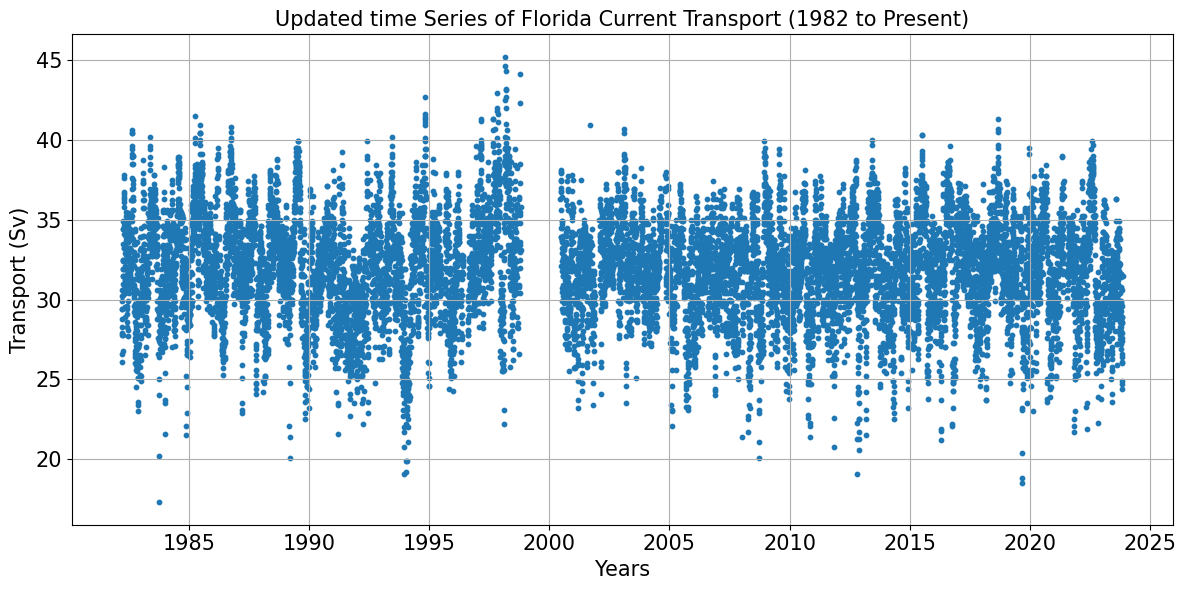

In [3]:
# Create a DataFrame
df=pd.DataFrame({'Date':pd.to_datetime({'year':years,'month':months,'day':days}),'Transport':transport,'Flag':flag})
df=df.dropna(subset=['Transport']) # Remove rows with NaN in Transport for plotting

plt.figure(figsize=(12,6))
plt.scatter(df['Date'],df['Transport'],color='C0',s=10)  # s=markers size
plt.xlabel('Years',fontsize=15)
plt.ylabel('Transport (Sv)',fontsize=15)
plt.title('Updated time Series of Florida Current Transport (1982 to Present)',fontsize=15)
plt.grid(True)
plt.tick_params(axis='both',which='major',labelsize=15)
plt.tight_layout()
plt.show()

In [4]:
# Set 'Date' column as the index 
df.set_index('Date', inplace=True)

# Group by year and month to compute the monthly means
monthly_data = df.groupby([df.index.year, df.index.month])

# Calculate the monthly mean, but only if the number of valid days (non-NaN) is at least 15 days
monthly_mean = monthly_data['Transport'].agg(lambda x: np.nan if len(x) <= 15 else np.mean(x))
monthly_mean.index = pd.to_datetime([f'{int(year)}-{int(month):02d}-01' for year, month in monthly_mean.index])

# Fill missing months with NaN
monthly_mean = monthly_mean.resample('M').mean()

# Find gaps 
gaps = monthly_mean.isna()

# Detect gaps smaller than or equal to 3 months, for that we will use rolling
small_gaps = gaps.rolling(window=4, min_periods=1).sum() <= 3

# Interpolate only for gaps of 3 months or fewer
monthly_mean_interpolated = monthly_mean.copy()
monthly_mean_interpolated[small_gaps] = monthly_mean_interpolated.interpolate()

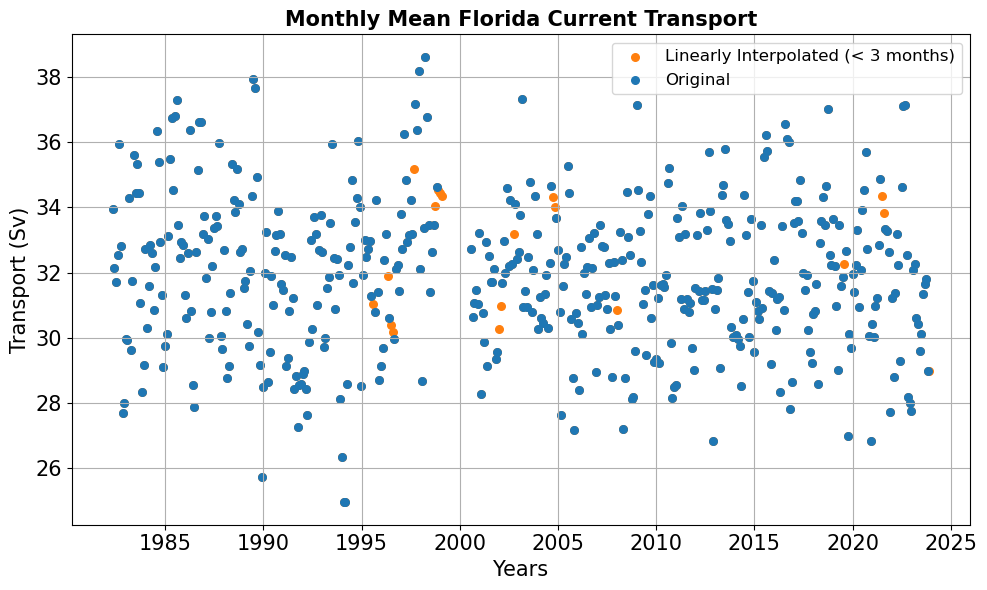

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(monthly_mean_interpolated.index, monthly_mean_interpolated, label='Linearly Interpolated (< 3 months)', color='C1',s=30)
plt.scatter(monthly_mean.index, monthly_mean, label='Original', color='C0',s=30)

plt.title('Monthly Mean Florida Current Transport', fontsize=15,weight='bold')
plt.xlabel('Years', fontsize=15)
plt.ylabel('Transport (Sv)', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True)
plt.tick_params(axis='both',which='major',labelsize=15)
plt.tight_layout()
plt.show()

In [6]:
# Find gaps (NaN values) in the interpolated data
gaps_interpolated = monthly_mean_interpolated.isna()

# Filter the months (index) where the values are NaN
missing_months = monthly_mean_interpolated.index[gaps_interpolated]

# Print the missing months and the total number of missing values
print(f"Missing values found in {len(missing_months)} months.")
print("Months with missing values:")
for month in missing_months:
    print(month)


Missing values found in 18 months.
Months with missing values:
1982-03-31 00:00:00
1999-02-28 00:00:00
1999-03-31 00:00:00
1999-04-30 00:00:00
1999-05-31 00:00:00
1999-06-30 00:00:00
1999-07-31 00:00:00
1999-08-31 00:00:00
1999-09-30 00:00:00
1999-10-31 00:00:00
1999-11-30 00:00:00
1999-12-31 00:00:00
2000-01-31 00:00:00
2000-02-29 00:00:00
2000-03-31 00:00:00
2000-04-30 00:00:00
2000-05-31 00:00:00
2000-06-30 00:00:00


In [7]:
# Create a new xarray.Dataset with the necessary variables for new plots
#ds = xr.Dataset({
 #   'fc_dates': monthly_mean_interpolated.index,
 #   'integrated_fc_trans_corrected': monthly_mean_interpolated,
#})

# Save the dataset to a NetCDF file
#ds.to_netcdf('/Users/cristinaarumiplanas/Documents/Papers_Cristina/University_Hamburg/Sverdrup/Data/Winds/fc_transports.nc')

In [8]:
# Now, i want to fill the remaining gap using a climatological annual cycle calculated based on the full record
# with a linear trend added to match the data in the years immediately before and after the gap.

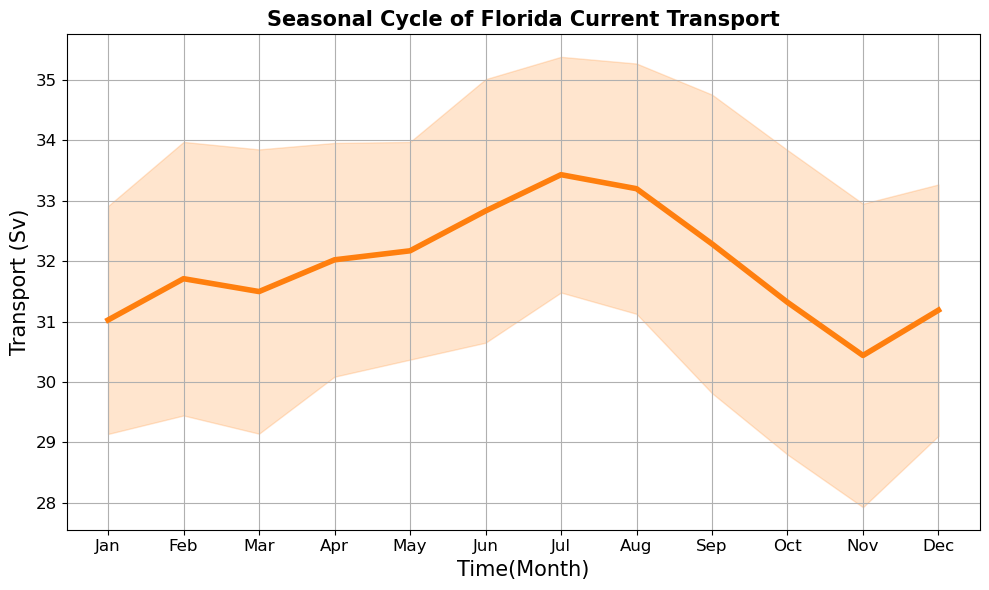

In [16]:
# Compute seasonal cycle and standard deviation
seasonal_cycle = monthly_mean_interpolated.groupby(monthly_mean_interpolated.index.month).mean()
seasonal_std = monthly_mean_interpolated.groupby(monthly_mean_interpolated.index.month).std()

plt.figure(figsize=(10, 6))
months = np.arange(1, 13)
plt.plot(seasonal_cycle.index, seasonal_cycle, color='C1', linewidth=4)
plt.fill_between(months,seasonal_cycle - seasonal_std, seasonal_cycle + seasonal_std, color='C1', alpha=0.2)
plt.title('Seasonal Cycle of Florida Current Transport', fontsize=15, weight='bold')
plt.xlabel('Time(Month)', fontsize=15)
plt.ylabel('Transport (Sv)', fontsize=15)
plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

In [ ]:
#Fill the 20 month gap using the seasonal